# Bird Migration Analysis

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import geopandas as gpd
import movingpandas as mpd
import folium
import os
import hvplot.pandas 
import shapely

import cartopy.feature as cfreature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from holoviews import opts, dim
from os.path import exists
from urllib.request import urlretrieve

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Firstly, load the data using a walk through the directory tree to find the csv file in the current directory. Load it into a dataframe

In [127]:
for root, dir, filenames in os.walk('.'):
    for filename in filenames:
        if filename.endswith('.csv'):
            file = os.path.join(root, filename)

dat = pd.read_csv(file, delimiter=',')

Get a brief overview of the data, seeing how many of the feature entries are not null, and their specific data types to see if we can cast new data types for more optimal reading. Its also a good check to see what percentage of the features is non-null to see if we need to treat them before further analysis

In [128]:
dat.info()

dat.isnull().sum()/len(dat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61920 entries, 0 to 61919
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          61920 non-null  int64  
 1   altitude            61920 non-null  int64  
 2   date_time           61920 non-null  object 
 3   device_info_serial  61920 non-null  int64  
 4   direction           61477 non-null  float64
 5   latitude            61920 non-null  float64
 6   longitude           61920 non-null  float64
 7   speed_2d            61477 non-null  float64
 8   bird_name           61920 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 4.3+ MB


Unnamed: 0            0.000000
altitude              0.000000
date_time             0.000000
device_info_serial    0.000000
direction             0.007154
latitude              0.000000
longitude             0.000000
speed_2d              0.007154
bird_name             0.000000
dtype: float64

So we can see that only two of the columns have non-null values, and they make up less than 1% of the total entries in each column, so we have little to be concerned about with them

In [129]:
dat = dat.drop(columns=['Unnamed: 0'])
dat.head(10)

,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name
0,71,2013-08-15 00:18:08+00,851,-150.469753,49.419860,2.120733,0.150000,Eric
1,68,2013-08-15 00:48:07+00,851,-136.151141,49.419880,2.120746,2.438360,Eric
2,68,2013-08-15 01:17:58+00,851,160.797477,49.420310,2.120885,0.596657,Eric
3,73,2013-08-15 01:47:51+00,851,32.769360,49.420359,2.120859,0.310161,Eric
4,69,2013-08-15 02:17:42+00,851,45.191230,49.420331,2.120887,0.193132,Eric
5,54,2013-08-15 02:47:38+00,851,-46.344478,49.420375,2.120840,2.904772,Eric
6,57,2013-08-15 03:02:33+00,851,-56.369922,49.420352,2.120901,3.080584,Eric
7,65,2013-08-15 03:17:27+00,851,-79.170227,49.420342,2.120809,2.199659,Eric
8,59,2013-08-15 03:32:35+00,851,-57.682428,49.420319,2.120860,2.640076,Eric
9,107,2013-08-15 03:47:48+00,851,119.604739,49.420287,2.121301,4.592211,Eric


Seeing the data types and afew rows of the data, we can see that only two rows could do with any type conversion: The `dat_time` to a Datetime format, and the `bird_name` to a string
On doing this, we should also look at the unique bird names, as we can plot the flight paths for each bird uniquely

In [130]:
dat['date_time'] = pd.to_datetime(dat['date_time'])
dat['bird_name'] = dat['bird_name'].astype(str)

dat['bird_name'].unique()

array(['Eric', 'Nico', 'Sanne'], dtype=object)

<Axes: xlabel='longitude', ylabel='latitude'>

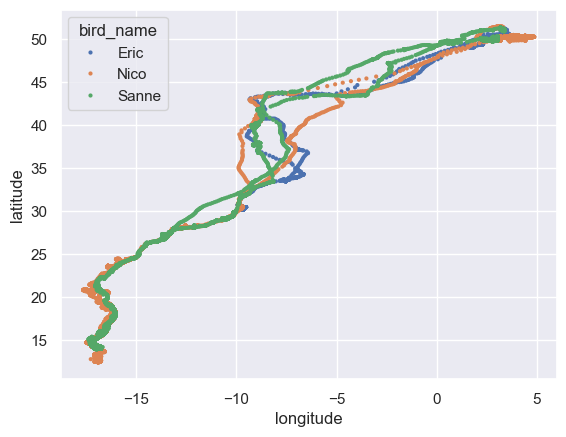

In [131]:
sns.scatterplot(data=dat, x='longitude', y='latitude', hue='bird_name', edgecolor='none', marker='.')

In [137]:
gdf = gpd.GeoDataFrame(dat.drop(['longitude', 'latitude'], axis=1), crs={'init': 'epsg:4326'},
geometry=dat.apply(lambda row: shapely.geometry.Point((row.longitude, row.latitude)), axis=1))

gdf

,altitude,date_time,device_info_serial,direction,speed_2d,bird_name,geometry
0,71,2013-08-15 00:18:08+00:00,851,-150.469753,0.150000,Eric,POINT (2.12073 49.41986)
1,68,2013-08-15 00:48:07+00:00,851,-136.151141,2.438360,Eric,POINT (2.12075 49.41988)
2,68,2013-08-15 01:17:58+00:00,851,160.797477,0.596657,Eric,POINT (2.12088 49.42031)
3,73,2013-08-15 01:47:51+00:00,851,32.769360,0.310161,Eric,POINT (2.12086 49.42036)
4,69,2013-08-15 02:17:42+00:00,851,45.191230,0.193132,Eric,POINT (2.12089 49.42033)
...,...,...,...,...,...,...,...
61915,11,2014-04-30 22:00:08+00:00,833,45.448157,0.208087,Sanne,POINT (3.17715 51.35257)
61916,6,2014-04-30 22:29:57+00:00,833,-112.073055,1.522662,Sanne,POINT (3.17714 51.35258)
61917,5,2014-04-30 22:59:52+00:00,833,69.989037,3.120545,Sanne,POINT (3.17726 51.35262)
61918,16,2014-04-30 23:29:43+00:00,833,88.376373,0.592115,Sanne,POINT (3.18151 51.35464)


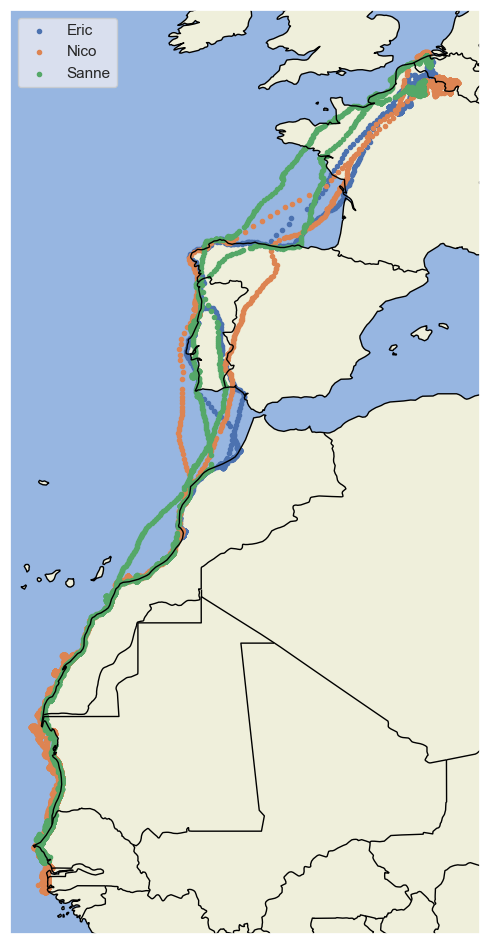

In [136]:
proj = ccrs.Miller()

plt.figure(figsize=(14,12))
ax = plt.axes(projection=proj)
ax.add_feature(cfreature.LAND)
ax.add_feature(cfreature.OCEAN)
ax.add_feature(cfreature.COASTLINE)
ax.add_feature(cfreature.BORDERS)

for name in dat['bird_name'].unique():
    filt = dat['bird_name'] == name
    long, lat = dat.longitude[filt], dat.latitude[filt]
    ax.scatter(long,lat,marker='.',transform=ccrs.Geodetic(),label=name)
plt.legend()
plt.show()

In [140]:
tc = mpd.TrajectoryCollection(gdf, 'bird_name', t='date_time', min_length=100)    
tc = mpd.MinTimeDeltaGeneralizer(tc).generalize(tolerance=timedelta(days=0.5))

tc_birdname = tc.filter('bird_name', 'Sanne')
traj = tc_birdname.trajectories[0].copy()
traj.df.head()


c:\Users\MMCCO\AppData\Local\Programs\Python\Python312\Lib\site-packages\movingpandas\trajectory.py:138: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. This is applied by doing df.tz_localize(None). To use UTC or a different time zone, convert and drop time zone information prior to trajectory creation.
  warnings.warn(
c:\Users\MMCCO\AppData\Local\Programs\Python\Python312\Lib\site-packages\movingpandas\trajectory.py:138: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. This is applied by doing df.tz_localize(None). To use UTC or a different time zone, convert and drop time zone information prior to trajectory creation.
  warnings.warn(
c:\Users\MMCCO\AppData\Local\Programs\Python\Python312\Lib\site-packages\movingpandas\trajectory.py:138: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. This is applied by doing df.tz

,altitude,device_info_serial,direction,speed_2d,bird_name,geometry
date_time,,,,,,
2013-08-15 00:01:08,55,833,-91.499509,0.372156,Sanne,POINT (2.28189 49.93106)
2013-08-15 12:05:06,76,833,-139.255074,0.338378,Sanne,POINT (2.65853 49.91329)
2013-08-16 00:53:23,65,833,-38.301802,0.468188,Sanne,POINT (2.34985 49.89957)
2013-08-16 12:54:58,92,833,-106.402875,0.136015,Sanne,POINT (2.69345 49.95830)
2013-08-17 00:55:32,100,833,-127.221985,0.557853,Sanne,POINT (2.79177 49.80266)


In [143]:
traj.hvplot(title=f"[{traj.id}] Migration Pattern", line_width=2)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

It then might be useful to look at the migration pattern by splitting into terms of yearly trips

In [147]:
trips_year = mpd.TemporalSplitter(tc_birdname).split(mode='year')
trips_year.to_traj_gdf()

,bird_name,start_t,end_t,geometry,length,direction
0,Sanne_2013-12-31 00:00:00,2013-08-15 00:01:08,2013-12-31 17:20:54,"LINESTRING (2.28189 49.93106, 2.65853 49.91329...",7.228494e+06,210.240225
1,Sanne_2014-12-31 00:00:00,2014-01-01 05:21:51,2014-04-30 23:59:34,"LINESTRING (-16.93035 13.95560, -16.80858 14.1...",7.359296e+06,19.202418


So only two years of migratory patterns are recorded. We can look at one year of trajectories

In [148]:
yr_one = trips_year.get_trajectory('Sanne_2013-12-31 00:00:00')
yr_one.add_speed(units=('km','h'))
yr_one

yr_one.hvplot(tite=f"Flight speed of {yr_one.id}", line_width=4, c='speed', colorbar=True)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)